# Crop/Split EEG Recording
DF, MD

Given a `.txt` file from the OpenBCI EEG, approximates trial start times, then crops and splits the recording into trials of N seconds. Results are saved both to the subject's folder and an all-encompassing folder, `all_splits `.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import csv
from datetime import datetime

import os
import shutil

from datasets.results import labels
label_list = labels

/Users/mercy/opt/anaconda3/envs/qmind2/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
subject = '1_MB'
trial_num = '1'
fp_prefix = f"/Users/mercy/Downloads/eeg/dataset_creation/datasets/{subject}"

at = ['right', 'front', 'right', 'front', 'right', 'front', 'front', 'right', 'right', 'left', 'front', 'right', 'left', 'front', 'front', 'left', 'right', 'left', 'front', 'left', 'right', 'left', 'left', 'right', 'left', 'right', 'left', 'front', 'front', 'left']
ao = ['left', 'right', 'left', 'left', 'left', 'right', 'front', 'left', 'front', 'front', 'left', 'right', 'front', 'front', 'front', 'right', 'right', 'right', 'left', 'right', 'right', 'front', 'left', 'left', 'front', 'left', 'right', 'front', 'front', 'right']
to = ['left', 'left', 'left', 'right', 'left', 'front', 'front', 'right', 'front', 'right', 'front', 'right', 'right', 'left', 'right', 'front', 'right', 'right', 'right', 'left', 'left', 'right', 'left', 'front', 'left', 'front', 'right', 'front', 'left', 'front', 'front']

# 1. Physically opening/closing fists with audio and text prompt
# 2. Imagining opening/closing fists with text only prompt
# 3. Imagining direction with audio and text prompt
# 4. Imagining direction with audio only prompt
# 5. Imagining direction with text only prompt
if trial_num==1 or trial_num==3:
    labels = labels['at']
elif trial_num==2 or trial_num==5:
    labels = labels['to']
else: # trial_num==4
    labels = labels['ao']

# Configuration
FILE_PATH = f"/{fp_prefix}/{subject}_{trial_num}.txt"
CHANNEL = 'Accel Channel 2' # Which channel to look at
SPIKE_OFFSET = 0  # Number of points to skip after detected noise
BASELINE_WINDOW = 40000  # Samples for noise baseline calculation
THRESHOLD_MULTIPLIER = 1  # Multiplier for noise threshold - default is 5

In [3]:
def get_sample_length(df):
    df, _ = load_data(FILE_PATH)
    # date_format = f"%Y-%m-%d %H:%M:%S"

    # Ensure Timestamp (Formatted) is a datetime object
    # df["Timestamp (Formatted)"] = pd.to_datetime(df["Timestamp (Formatted)"])
    # 2025-02-13 17:55:37.991
    # YYYY-MM-DD HH:MM:SS.SSS
    df["Timestamp (Formatted)"] = pd.to_datetime(df["Timestamp (Formatted)"])

    # df["Timestamp (Formatted)"] = datetime.strptime(df["Timestamp (Formatted)"], date_format)

    df["Second"] = df["Timestamp (Formatted)"].dt.strftime("%H:%M:%S")
    grouped_arrays = [group for _, group in df.groupby("Second")]
    grouped_arrays = [group.to_numpy() for group in grouped_arrays]
    return len(grouped_arrays)


def load_data(file_path):
    with open(file_path) as f:
        headers = [next(f) for _ in range(4)]
        actual_header = f.readline().strip()
    
    # Clean column names to ensure uniqueness
    columns = [col.strip() for col in actual_header.split(',')]
    columns = [f"{col}_{i}" if columns[:i].count(col) > 0 else col 
               for i, col in enumerate(columns)]
    
    # Load data
    df = pd.read_csv(file_path, skiprows=5, names=columns)
    
    return df, headers

def trim_signal(signal, start, end, fs=250):
    # Calculate baseline noise
    baseline_signal = signal[:BASELINE_WINDOW]
    baseline_std = np.std(baseline_signal)
    threshold = np.median(baseline_signal) + THRESHOLD_MULTIPLIER * baseline_std

    # Find peaks with minimum prominence
    peaks, _ = find_peaks(signal, height=threshold, prominence=baseline_std*3)
    print(peaks)

    cutoff_start = start*250
    
    if len(peaks) > 0:
        if peaks[0] > cutoff_start:
            cutoff_idx = cutoff_start
            cutoff_time = start
        else:
            cutoff_idx = peaks[0]
            cutoff_time = cutoff_idx/250
    else:
        cutoff_idx = cutoff_start
        cutoff_time = start

    # # Trim data
    trimmed_signal = signal[cutoff_idx:cutoff_idx + 37500] # 37500 = 250*150
    
    # return 0, 1
    print(cutoff_time, cutoff_start)
    return trimmed_signal, cutoff_idx
    
def separate_signal(signal):
    separated_signals = []
    i = 0
    
    while i < 362251:
        separated_signals.append(signal[i:i+1250])
        i += 1250
    
    return separated_signals


def save_to_csv(separated, base_filename="MB_data"):
    for i, array in enumerate(separated):
        # Convert the array to a DataFrame
        df = pd.DataFrame(array)
        
        # Define the filename
        filename = f"{base_filename}_{i}.csv"
        
        # Save to CSV
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")


In [4]:
def split_trimmed_signal(trimmed_signal, trial_num=30, trial_in_secs=5): # trimmed_signal is a df
    split_signals = []
    trial_length = 250*trial_in_secs # 5 sec trials
    for i in range(trial_num):
        new_trimmed_sig = trimmed_signal.iloc[trial_length*i:trial_length*(i+1)]
        split_signals.append(new_trimmed_sig)
    # print(len(split_signals))
    return split_signals


def save_signals(splits, folder, labels): # splits is an array of dataframes
    trial_order = 0
    for s in splits:
        filename = f"{folder}/{subject}_{trial_num}_{trial_order}_{labels[trial_order]}.csv"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        s.to_csv(filename, index=False)  

        filename = f"{fp_prefix[:-4]}/all_splits/{subject}_{trial_num}_{trial_order}_{labels[trial_order]}.csv"
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        s.to_csv(filename, index=False)  
        # np.savetxt(filename,s,delimiter=",")
        # with open(f"{fp_prefix}/splits/{subject}_{trial_num}_{trial_order}_{label}.csv","w+") as my_csv:
        #     csvWriter = csv.writer(my_csv, delimiter=',')
        #     csvWriter.writerows(s)
        trial_order += 1


def reset_splits_folder(folder):
    for item in os.listdir(folder):
        item_path = os.path.join(folder, item)
        if os.path.isdir(item_path):  # Check if it's a folder
            shutil.rmtree(item_path)  # Delete the folder
    # for filename in os.listdir(folder):
    #     file_path = os.path.join(folder, filename)
    #     try:
    #         if os.path.isfile(file_path) or os.path.islink(file_path):
    #             os.unlink(file_path)
    #         elif os.path.isdir(file_path):
    #             shutil.rmtree(file_path)
    #     except Exception as e:
    #         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [5]:

def plot_signals(original_sig, trimmed_sig, cutoff_idx, fs=250):
    """Plot comparison of original and trimmed signals"""
    plt.figure(figsize=(12, 6))
    
    # Original signal plot
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(original_sig))/fs, original_sig, label='Original Signal')
    plt.axvline(cutoff_idx/fs, color='r', linestyle='--', 
              label=f'Cutoff ({cutoff_idx/fs:.2f}s)')
    plt.title('Original Signal with Clap Detection')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # Trimmed signal plot
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(trimmed_sig))/fs + cutoff_idx/fs, 
           trimmed_sig, color='g', label='Trimmed Signal')
    plt.title('Adjusted Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def create_splits_folder(FILE_PATH, labels):
    # Load data
    df, headers = load_data(FILE_PATH)
    
    # Detect spike
    signal = df[CHANNEL].values
    sample_length = get_sample_length(df)
    if sample_length < 150:
        raise Exception('sample too short')
    print(sample_length)
    
    # pick default start and end points
    max_start = sample_length - 150 # last possible start of sample
    min_end = 150 # first possible end of sample

    # get array of one channel and starting cutoff
    trimmed_arr, cutoff_idx = trim_signal(signal, max_start, min_end)
    trimmed_signal = df[cutoff_idx:cutoff_idx + 37500]
    # separated = separate_signal(trimmed_signal)
    # print(len(split_trimmed_signal(trimmed_signal)))

    # get array of each signal
    splits = split_trimmed_signal(trimmed_signal, trial_num=30, trial_in_secs=5)

    folder = f"{fp_prefix}/{subject}_{trial_num}_splits"
    os.makedirs(os.path.dirname(folder+"/test.txt"), exist_ok=True)
    save_signals(splits, folder, labels)

    print(f"Data starts at: {cutoff_idx/250:.2f} s")
    
    # Generate plots
    plot_signals(signal, trimmed_arr, cutoff_idx)
    
    print(len(signal))
    
    # save_to_csv(separated)
    
    

# if __name__ == "__main__":
#     main()

218
[ 6195  9124 51393 53045]
24.78 17000
Data starts at: 24.78 s


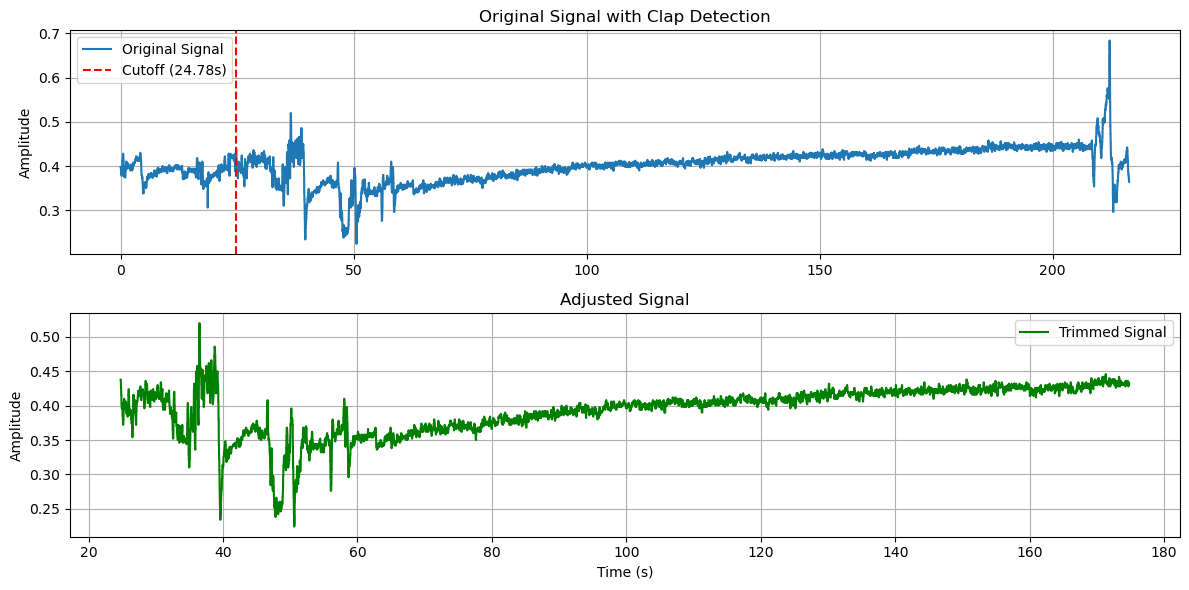

54094
167
[ 1435 39977]
5.74 4250
Data starts at: 5.74 s


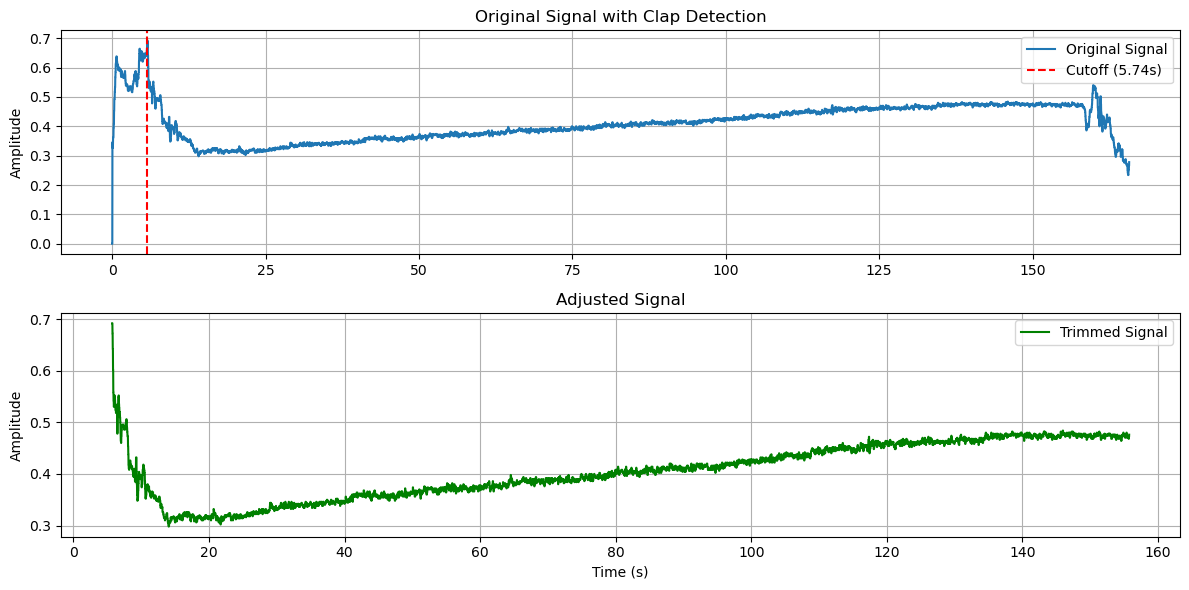

41439
178
[   64  3919 43447]
0.256 7000
Data starts at: 0.26 s


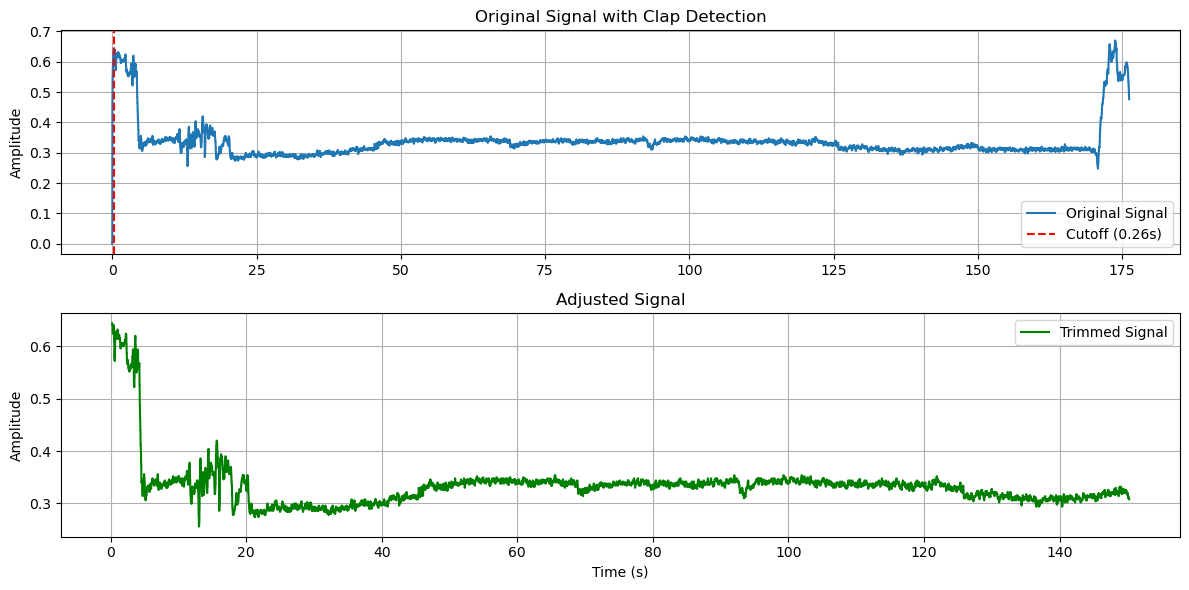

44054
167
[  646 40733]
2.584 4250
Data starts at: 2.58 s


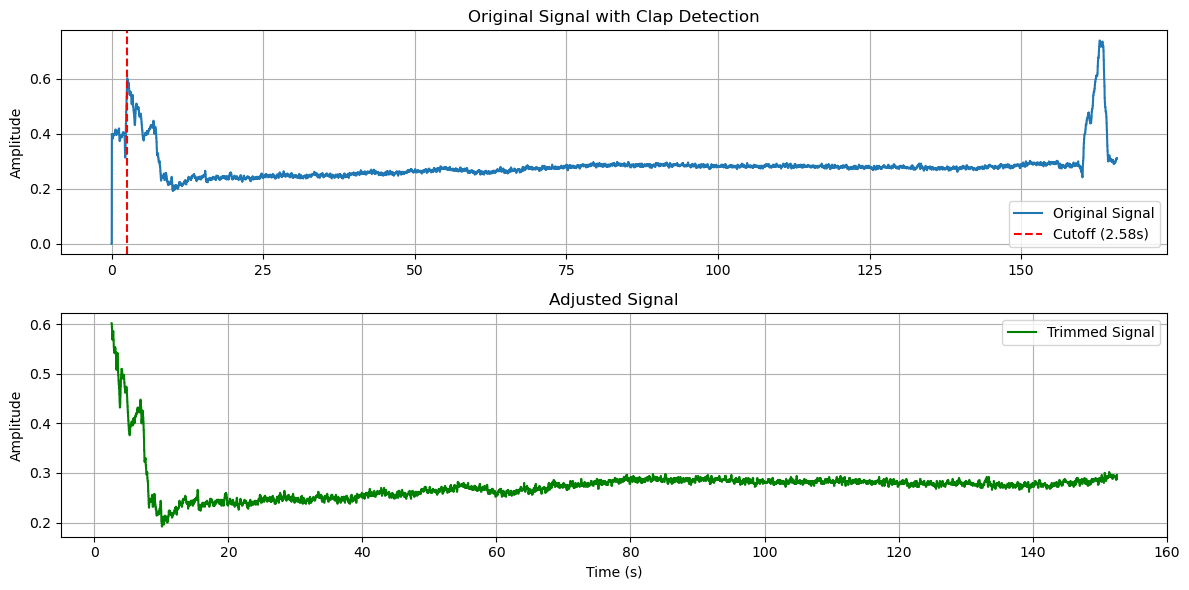

41445
161
[16370]
11 2750
Data starts at: 11.00 s


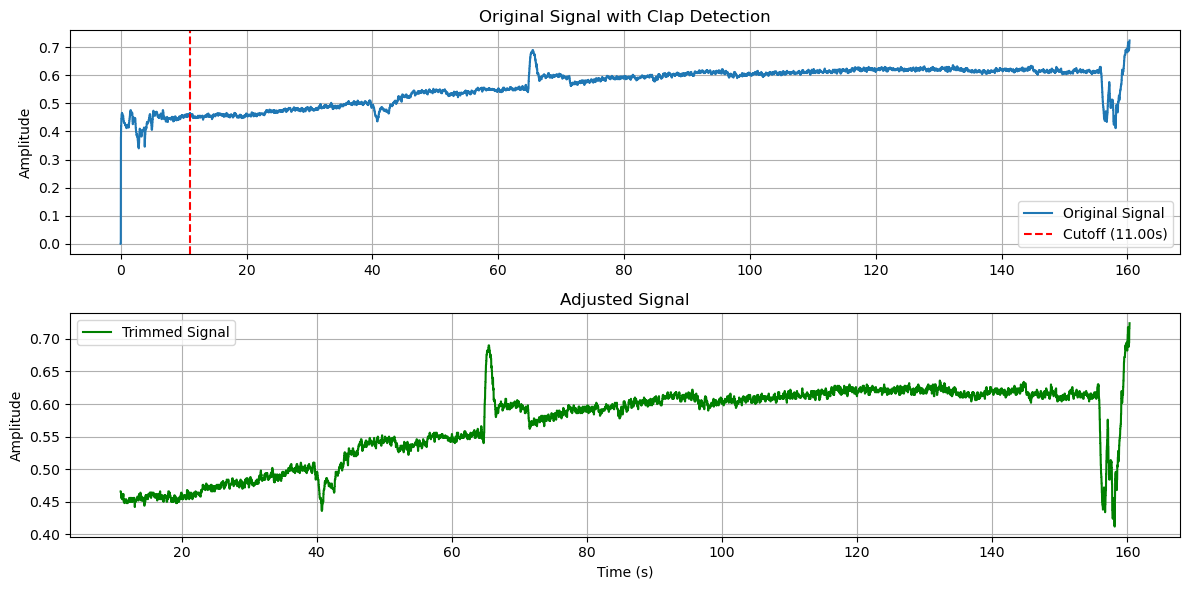

40083
191
[33112]
41 10250
Data starts at: 41.00 s


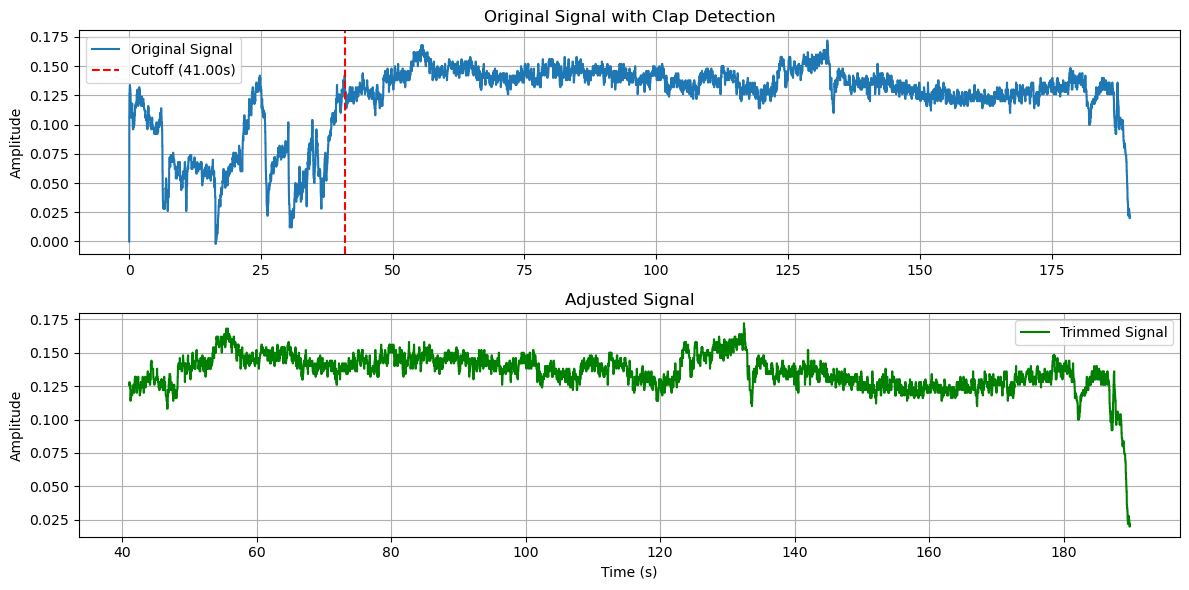

47471
186
[  675   735   902 13733 20597 20646]
2.7 9000
Data starts at: 2.70 s


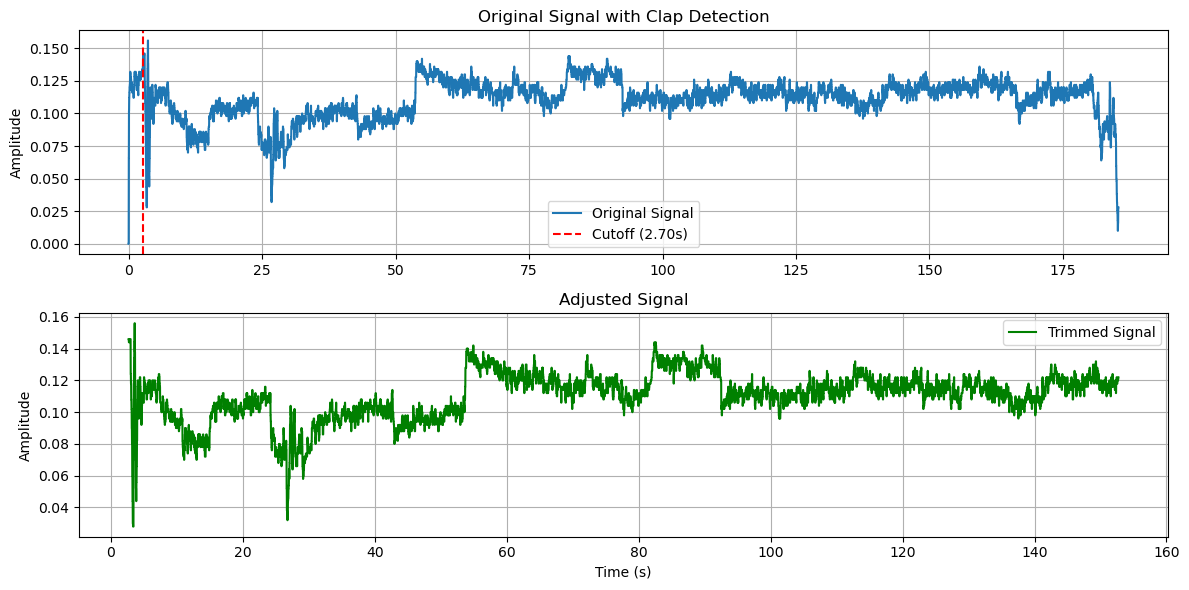

46343
177
[  828  2988 39006 41166 43968]
3.312 6750
Data starts at: 3.31 s


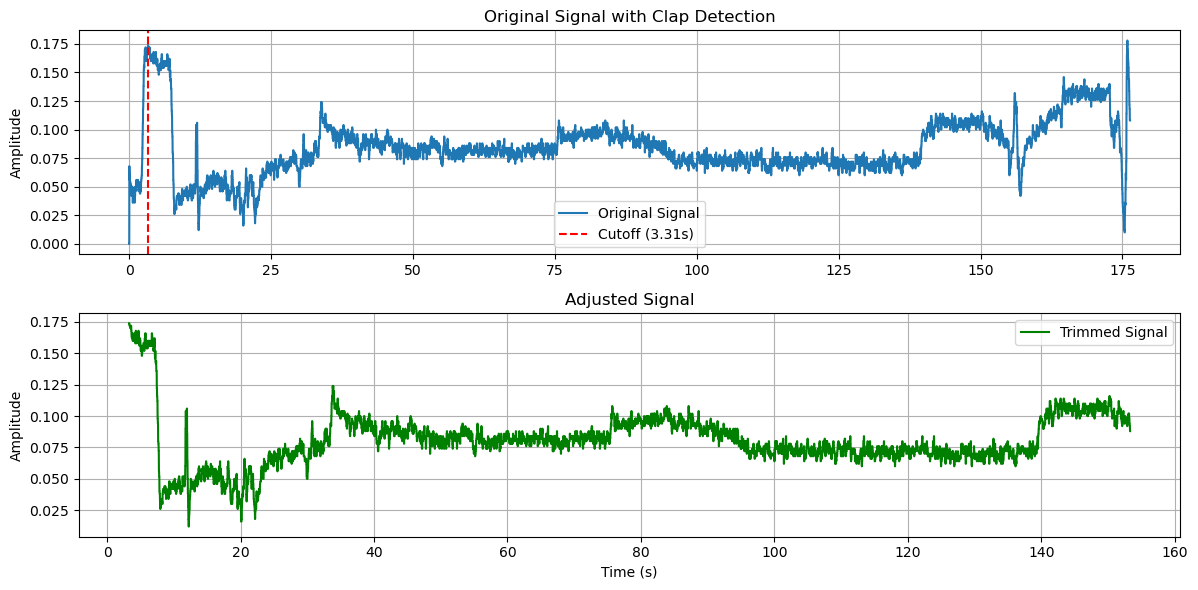

44088
184
[25735]
34 8500
Data starts at: 34.00 s


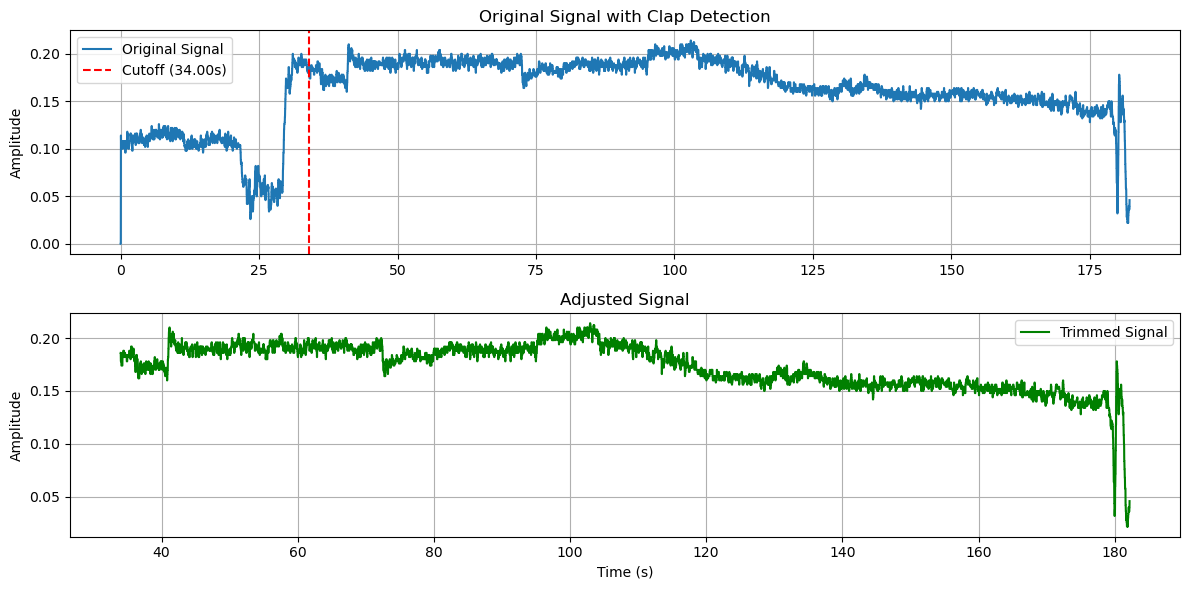

45546
174
[ 6390  7110 43108]
24 6000
Data starts at: 24.00 s


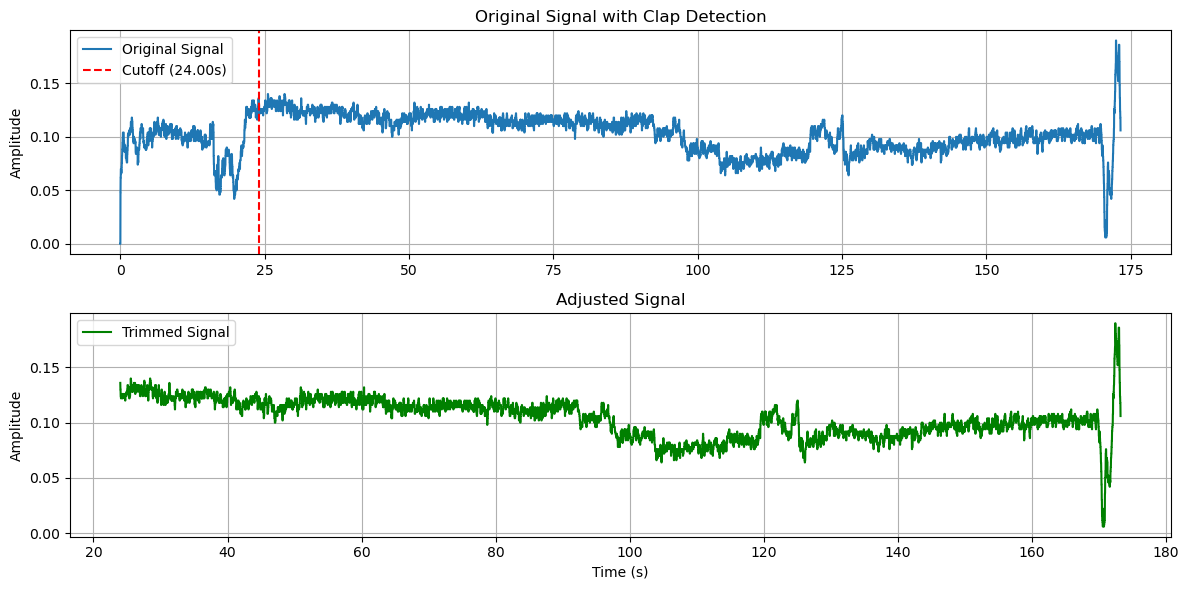

43306
166
[27481 28867 28941 28965]
16 4000
Data starts at: 16.00 s


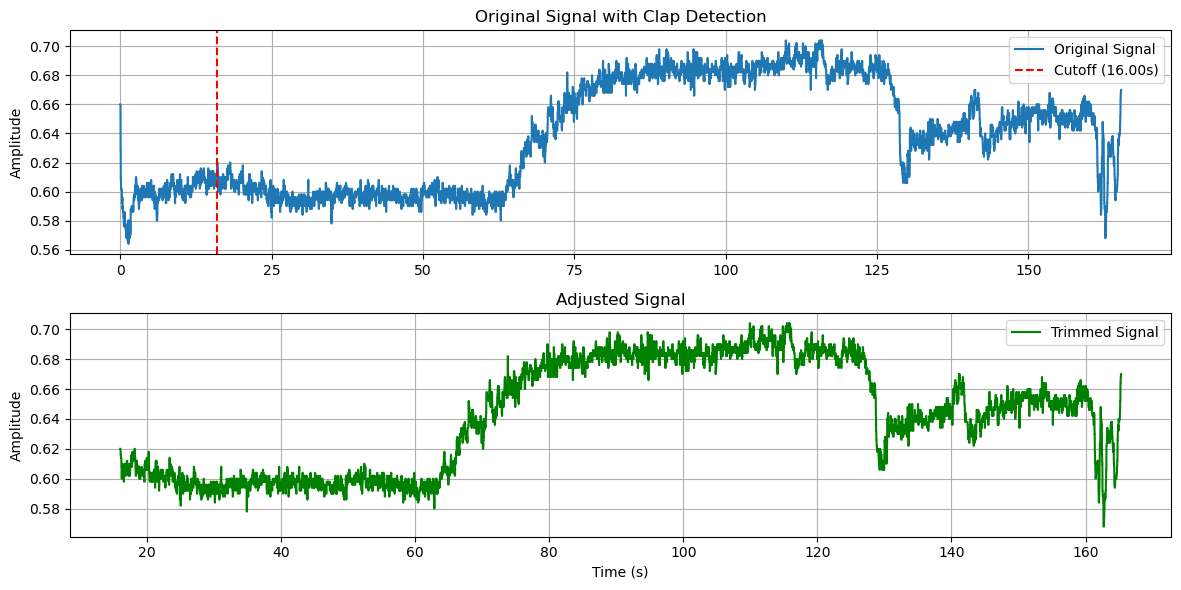

41328
171
[19082]
21 5250
Data starts at: 21.00 s


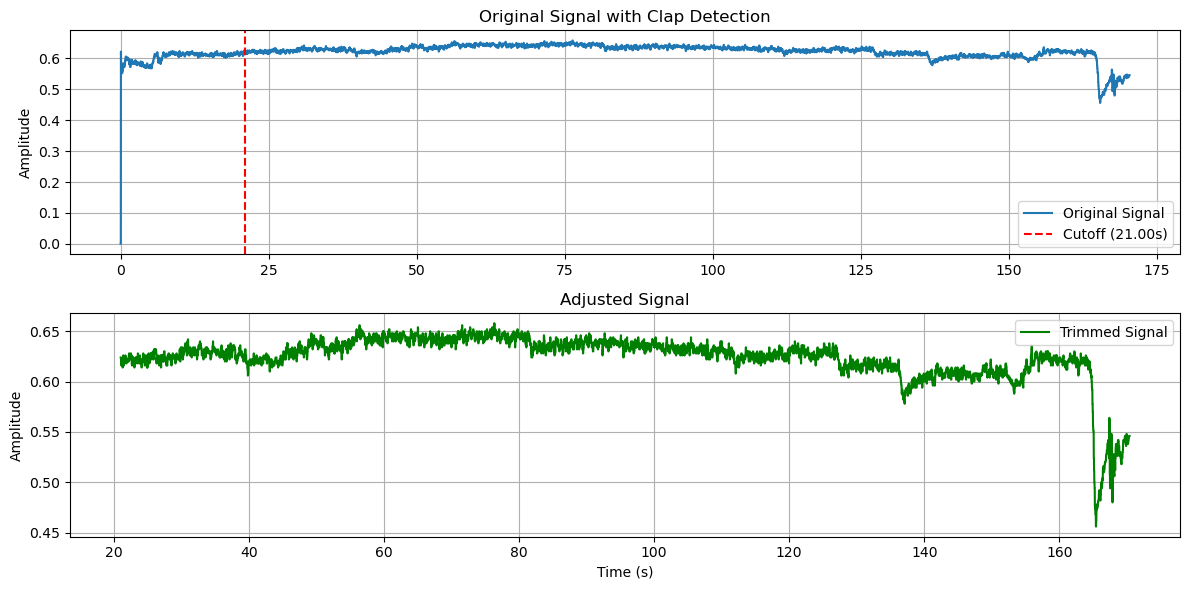

42601
Failed: //Users/mercy/Downloads/eeg/dataset_creation/datasets/3_FJ/3_FJ_3.txt
Failed: //Users/mercy/Downloads/eeg/dataset_creation/datasets/3_FJ/3_FJ_4.txt
174
[ 2165  2461  2644 42520]
8.66 6000
Data starts at: 8.66 s


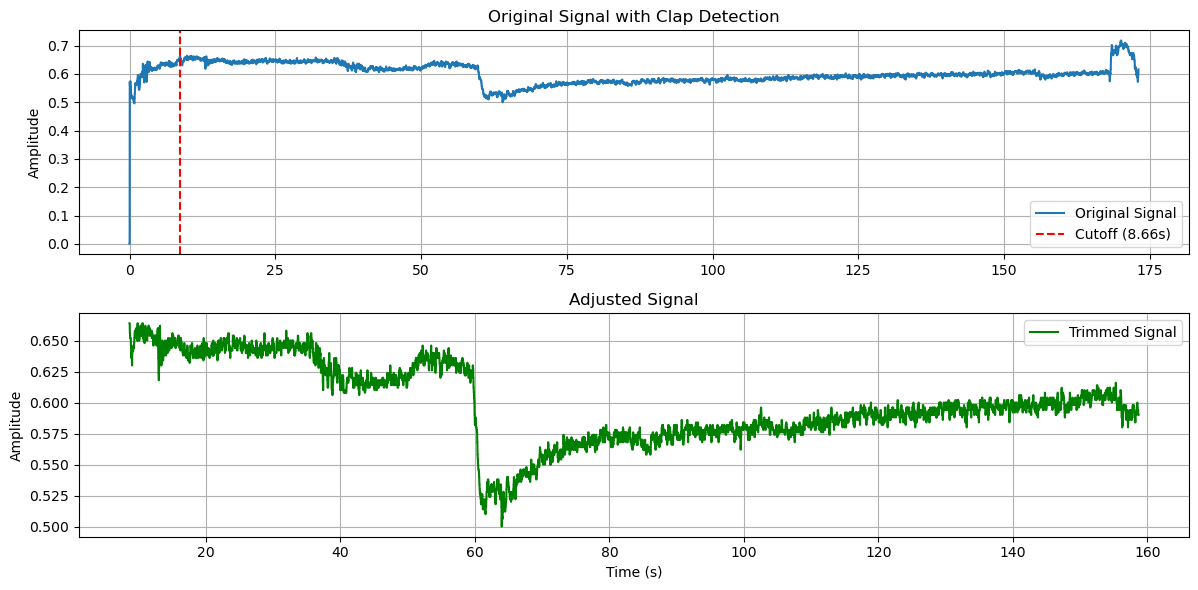

43268
179
[44364]
29 7250
Data starts at: 29.00 s


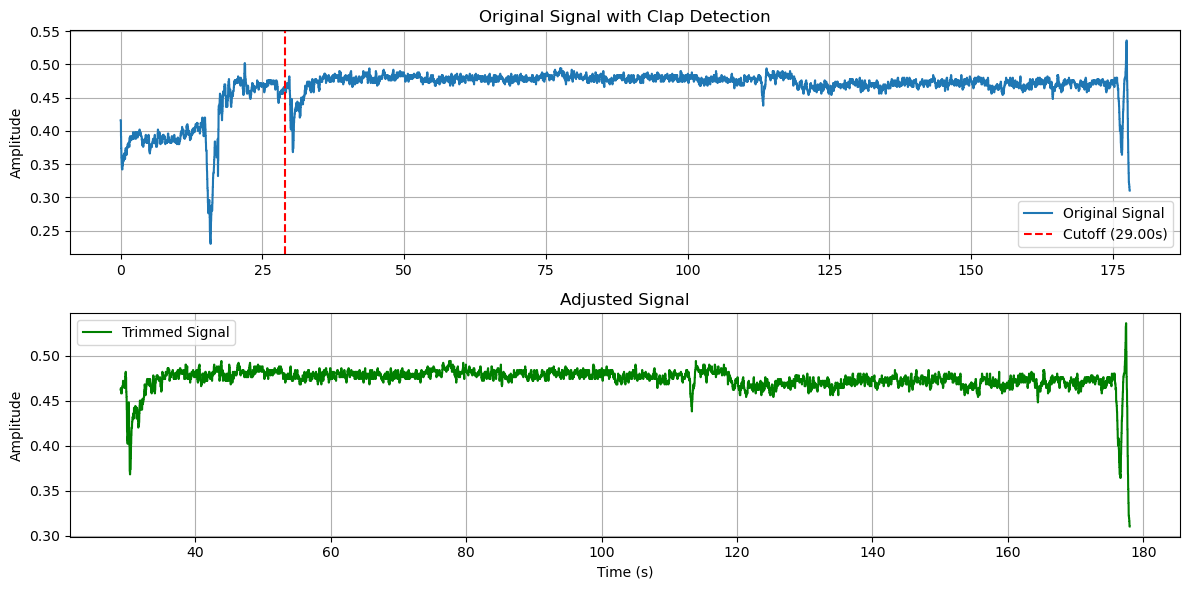

44495
178
[  577  3565 40627]
2.308 7000
Data starts at: 2.31 s


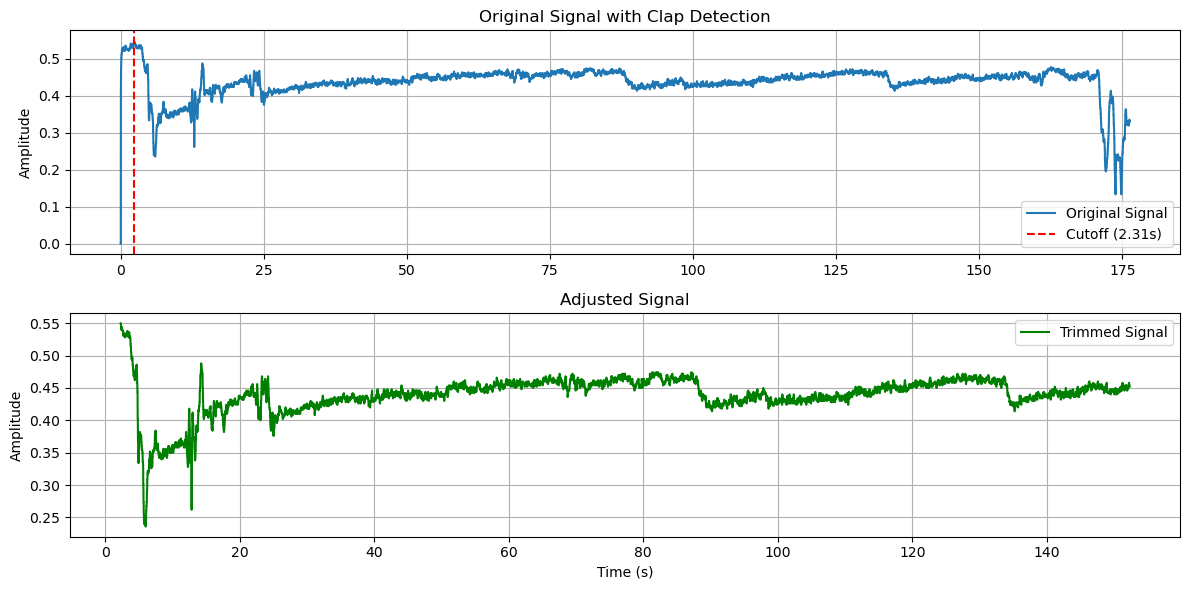

44070
164
[20723]
14 3500
Data starts at: 14.00 s


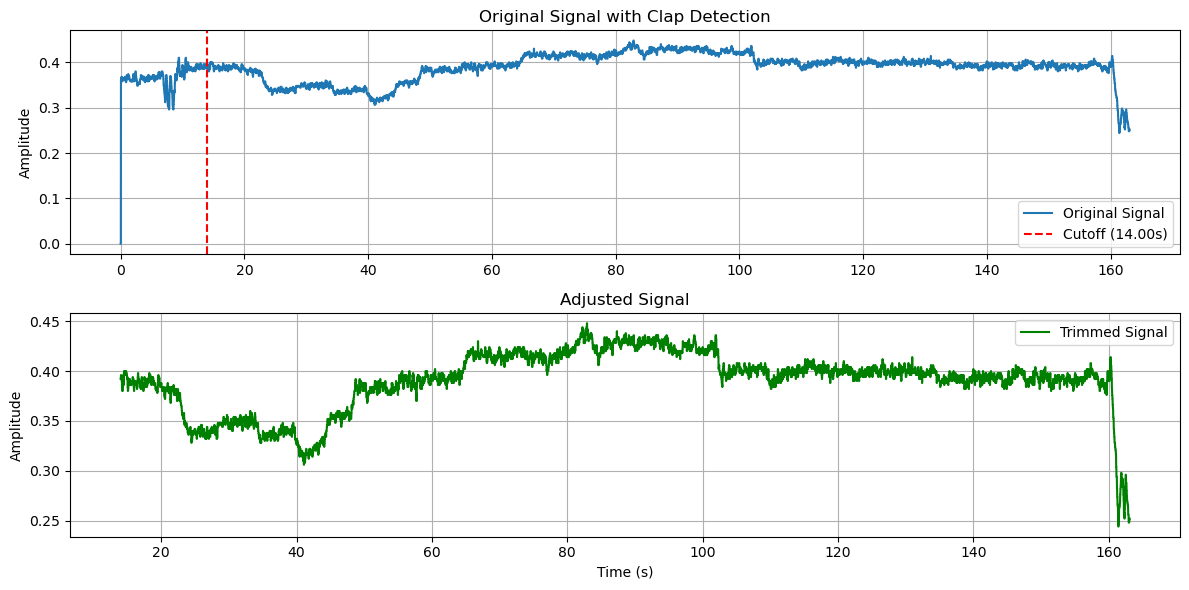

40769
184
[2886 4829 5017 7088]
11.544 8500
Data starts at: 11.54 s


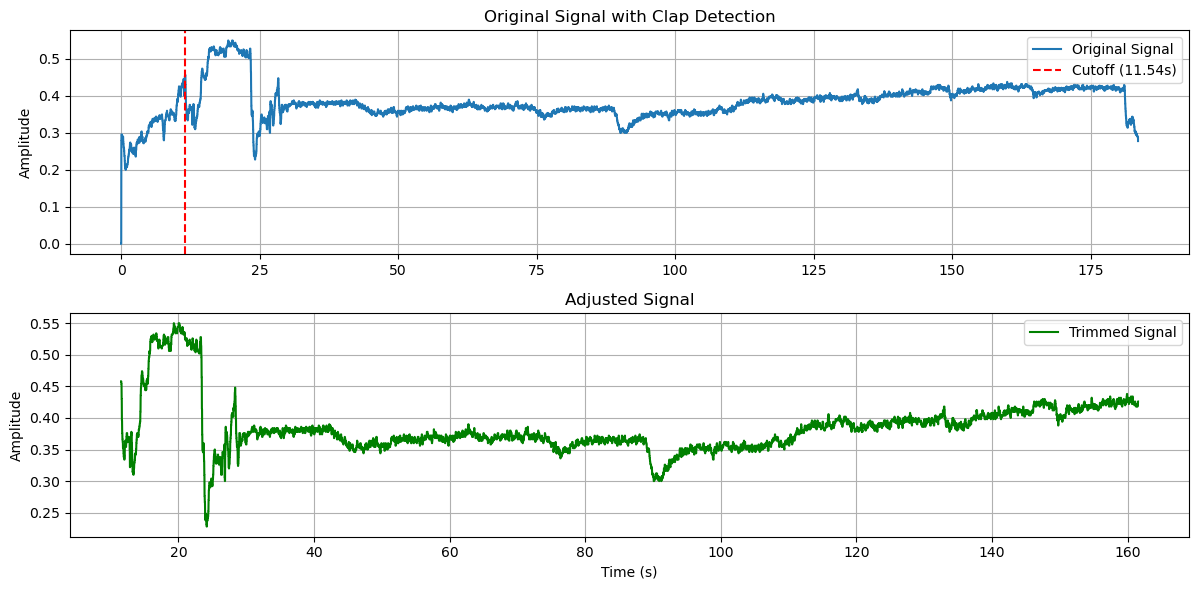

45885
165
[ 2600 27255]
10.4 3750
Data starts at: 10.40 s


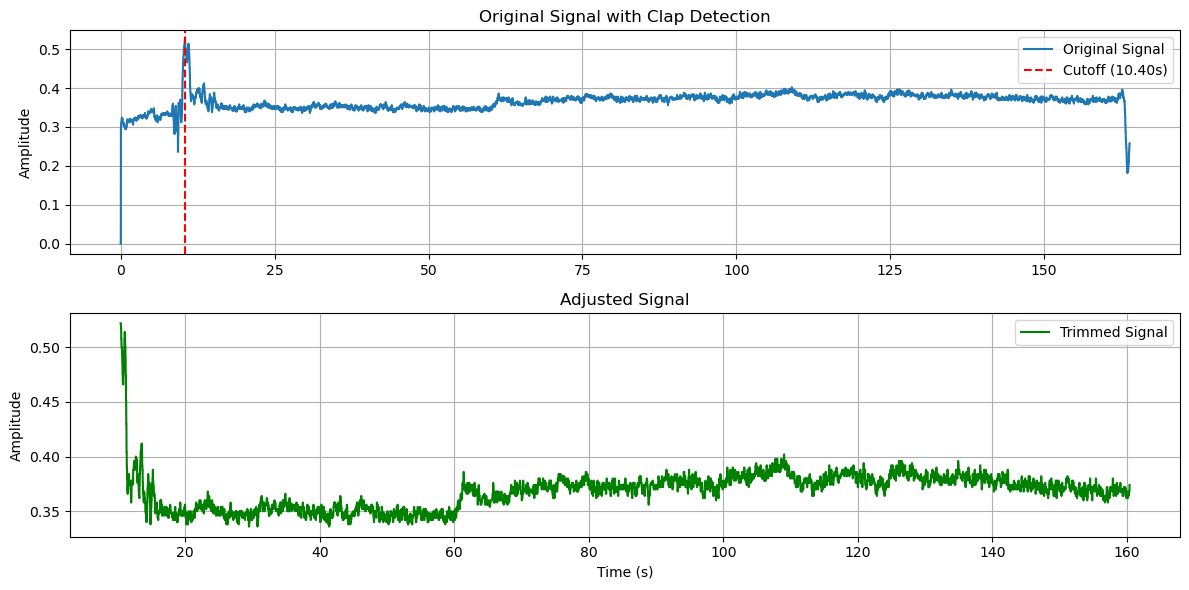

40972
169
[ 2843 16674 17607 17903 21725 29054 29207 32999 41276 41759]
11.372 4750
Data starts at: 11.37 s


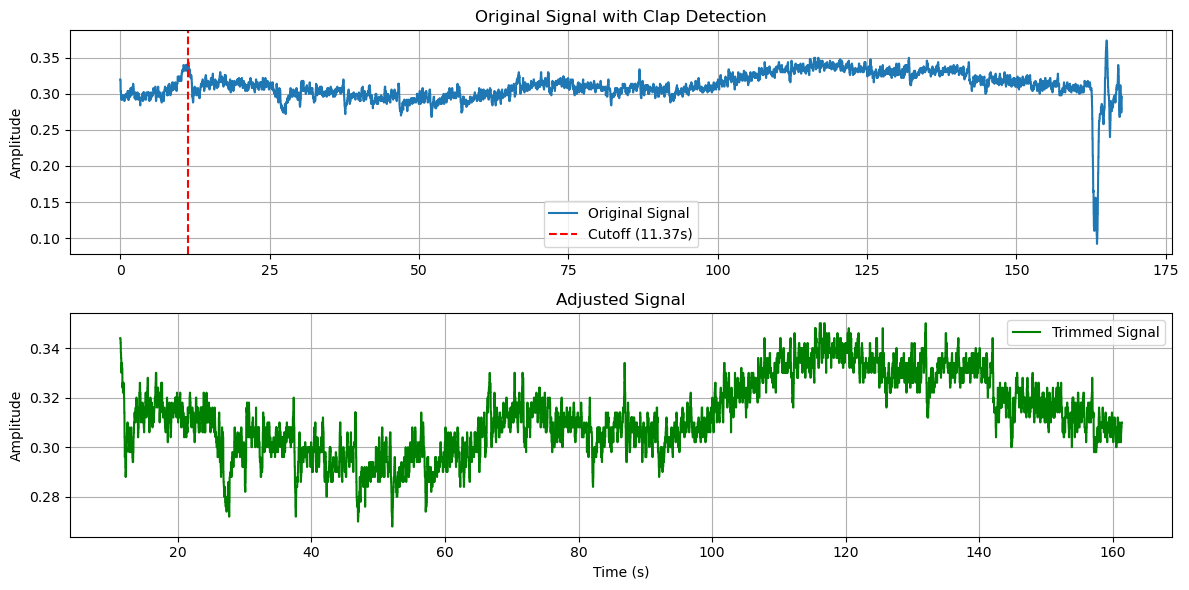

41909
167
[   35   144  5953  6259  6417 14594 30220 31355 38922 40767 41310 41507]
0.14 4250
Data starts at: 0.14 s


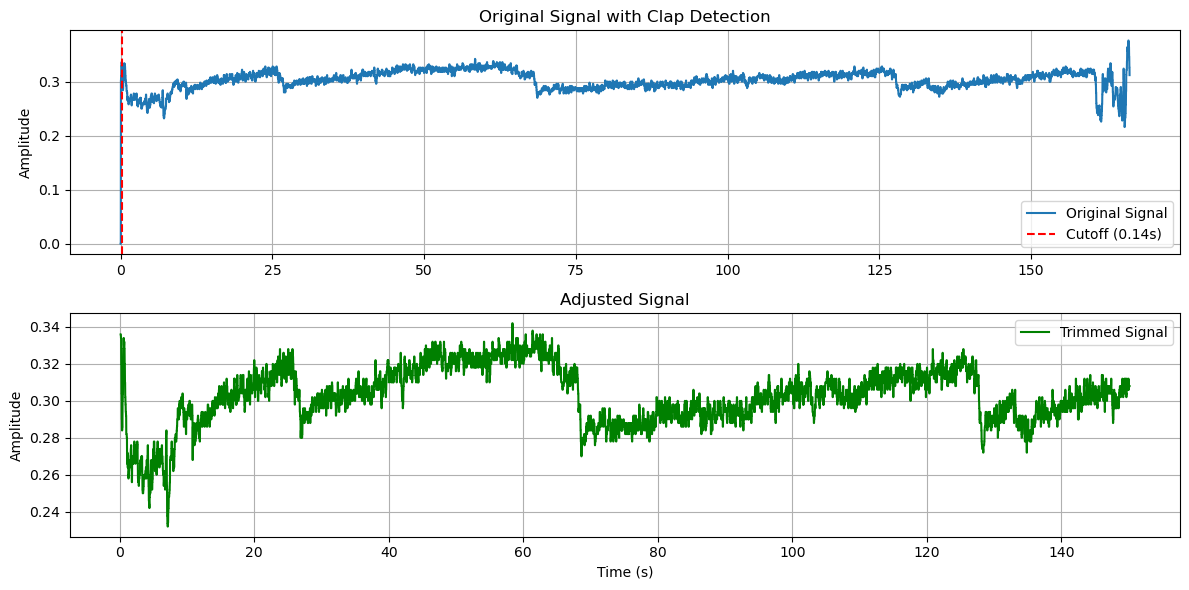

41556
Failed: //Users/mercy/Downloads/eeg/dataset_creation/datasets/5_CB/5_CB_3.txt
Failed: //Users/mercy/Downloads/eeg/dataset_creation/datasets/5_CB/5_CB_4.txt
174
[]
24 6000
Data starts at: 24.00 s


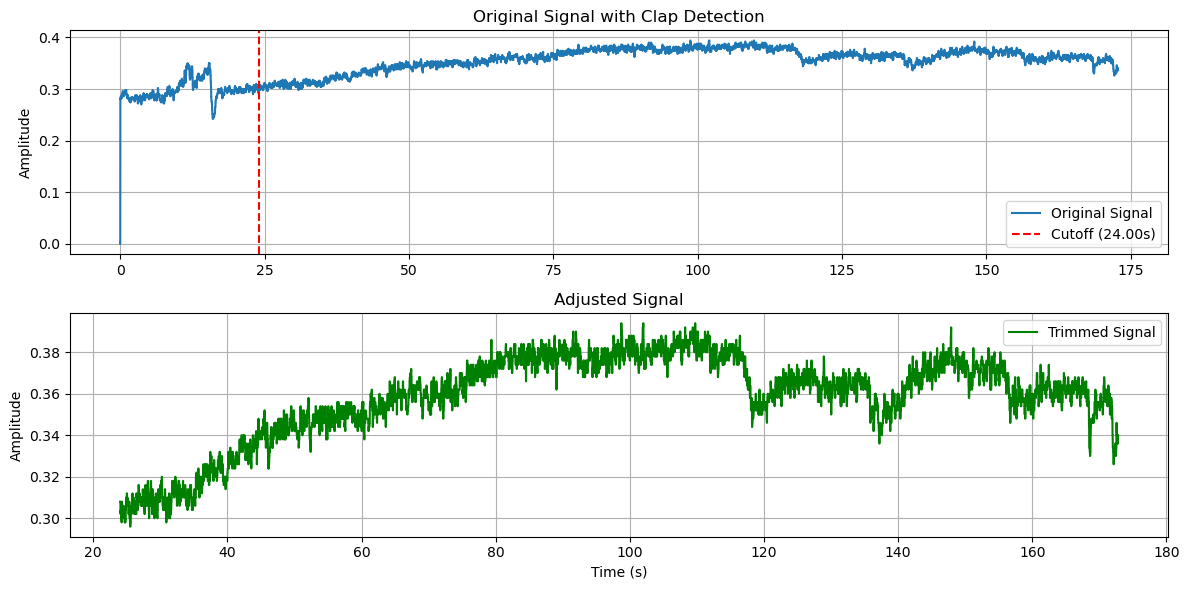

43195
177
[ 5896 34014 34260 34329 37724 39855 39949 40047 40151]
23.584 6750
Data starts at: 23.58 s


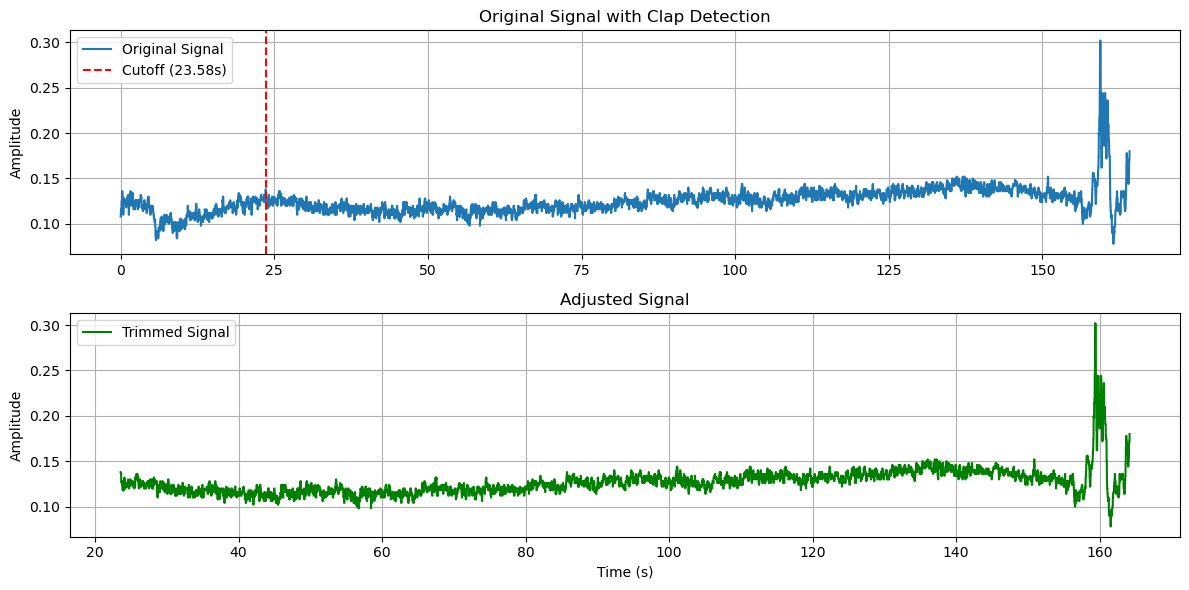

41048
175
[  224 14460 17449 18767 19215 22570 28657 42185]
0.896 6250
Data starts at: 0.90 s


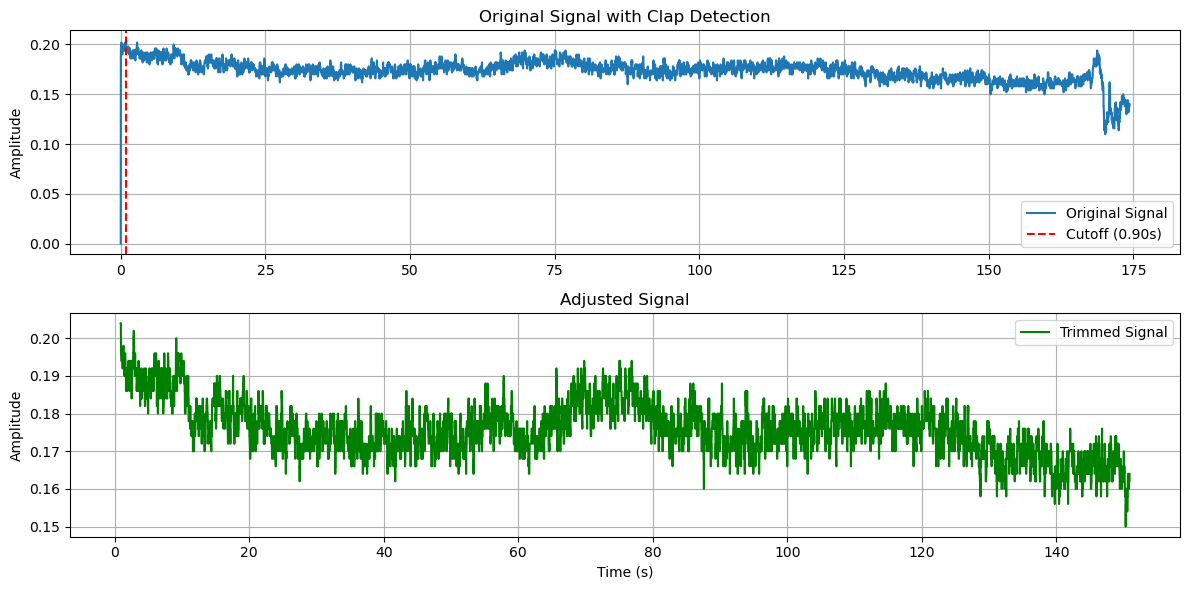

43585
Failed: //Users/mercy/Downloads/eeg/dataset_creation/datasets/6_FC/6_FC_3.txt
Failed: //Users/mercy/Downloads/eeg/dataset_creation/datasets/6_FC/6_FC_4.txt
194
[ 676 1041 1623 1716 2451 2501 4074]
2.704 11000
Data starts at: 2.70 s


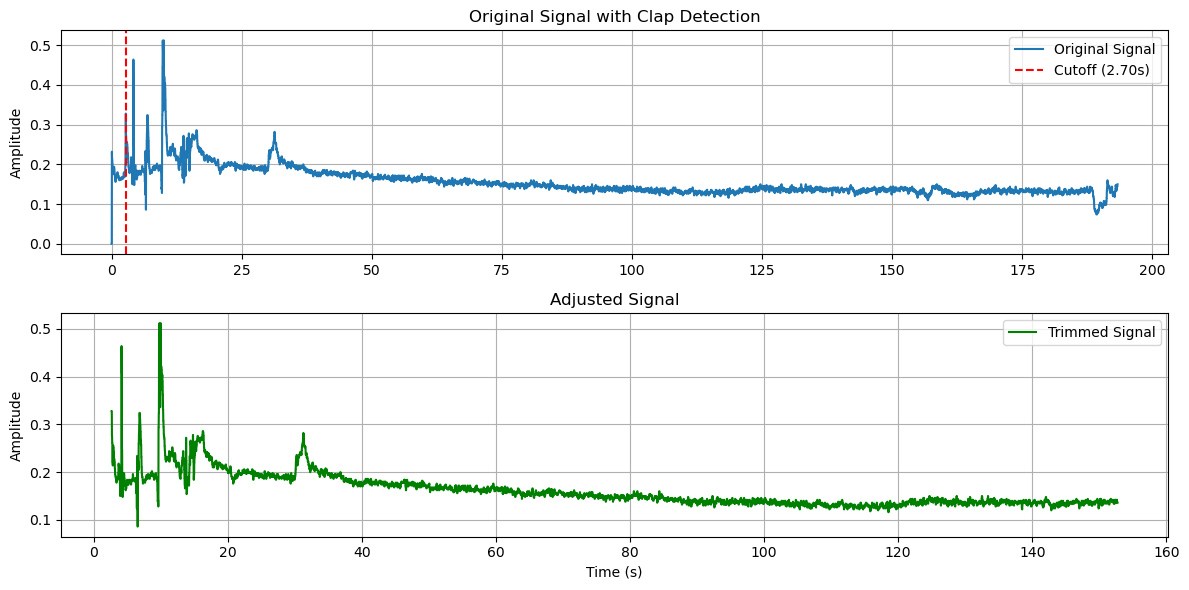

48325


In [6]:
subjects = ['1_MB', '2_FA', '3_FJ', '4_MG', '5_CB', '6_FC']
label_prefixes = ['', 'p_andr_30', 'p_jasm_30', 'p_gunt_30', 'p_cat_30', 'p_cat_30']

# generate folders for all subjects
for idx in range(len(subjects)):
    s = subjects[idx]
    lp = label_prefixes[idx]
    subject = s
    fp_prefix = f"/Users/mercy/Downloads/eeg/dataset_creation/datasets/{subject}"
    reset_splits_folder(fp_prefix)
    for idx in range(5):
        trial_num = idx + 1
        
        if trial_num==1 or trial_num==3:
            labels = label_list[lp + 'at']
        elif trial_num==2 or trial_num==5:
            labels = label_list[lp + 'to']
        else: # trial_num==4
            labels = label_list[lp + 'ao']

        # Configuration
        FILE_PATH = f"/{fp_prefix}/{subject}_{trial_num}.txt"
        try:
            create_splits_folder(FILE_PATH, labels)
        except:
            print(f"Failed: {FILE_PATH}")